# Matrix Factorization: Experiments and Evaluation

This notebook implements and compares two classical MF recommendation paradigms:
1. **FunkSVD**
2. **Alternative Least Squares (ALS)**

Both model use low-rank approximation for user-ratings matrix, but differ in optimization strategy: FunkSVD uses stochastic gradient descent (SGD) to iteratively update user- and item- matrix parameters on each epoch, while ALS iteratively fixes one matrix, solves ridge regression for second matrix, then fixes second matrix and solves for the first one until convergence. We use explicit implementations of these algorithm, meaning we try to predict rating of the item. 

In [3]:
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from src.data.loader import load_all_data
from src.data.splitter import create_temporal_split, SplitConfig, add_random_timestamps, UserTemporalSplitConfig
from src.models import ContentBasedRecommender, ItemItemCFRecommender, FunkSVD, FunkSVDConfig, ALS, ALSConfig
from src.evaluation import (
    EvaluationPipeline,
    GlobalMeanBaseline,
    UserMeanBaseline,
    ItemMeanBaseline,
    PopularityBaseline,
    print_evaluation_results,
)

plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

## 1. Data Loading and Temporal Split

For this task temporal split we use differs from similarity recommendation algorithms. If we split by the year the book was published, matrix factorization inherently make no sense, as all of the validation and test books will face cold start problem. Therefore we create random variable timestamp, that simulates time the book was rated. Then, for each user we order ratings by timestamp and split train/val/test with 0.7/0.15/0.15 ratio, so that older books go in train and newer into validation and test. This creates simulation of temporal data.

In [4]:
# Load data
ratings, books, users = load_all_data('../data/raw')

ratings_ts = add_random_timestamps(ratings, start="2004-08-01", end="2004-09-30", seed=123, ts_col="timestamp")



In [18]:
# Initialize evaluation pipeline
K_VALUES = [5, 10, 20]
pipeline = EvaluationPipeline(k_values=K_VALUES, relevance_threshold=6.0)

# Store all results
all_results = {}

## 2. Baseline Models

We first establish baselines to compare against.

In [19]:
# Global Mean Baseline
global_mean = GlobalMeanBaseline()
global_mean.fit(train_df)
all_results['Global Mean'] = pipeline.evaluate_rating_prediction(global_mean, test_df)
print(f"Global Mean → RMSE: {all_results['Global Mean']['rmse']:.4f}, MAE: {all_results['Global Mean']['mae']:.4f}")

# User Mean Baseline
user_mean = UserMeanBaseline()
user_mean.fit(train_df)
all_results['User Mean'] = pipeline.evaluate_rating_prediction(user_mean, test_df)
print(f"User Mean  → RMSE: {all_results['User Mean']['rmse']:.4f}, MAE: {all_results['User Mean']['mae']:.4f}")

# Item Mean Baseline
item_mean = ItemMeanBaseline()
item_mean.fit(train_df)
all_results['Item Mean'] = pipeline.evaluate_rating_prediction(item_mean, test_df)
print(f"Item Mean  → RMSE: {all_results['Item Mean']['rmse']:.4f}, MAE: {all_results['Item Mean']['mae']:.4f}")

Global Mean → RMSE: 1.7820, MAE: 1.4080
User Mean  → RMSE: 1.6453, MAE: 1.2395
Item Mean  → RMSE: 1.8142, MAE: 1.4228


## 3. Alternative Least Squares

### 3.1 Users with minimum 5 interactions

In [79]:
# Create temporal split
config = UserTemporalSplitConfig(
    train_frac=0.7,
    val_frac=0.15,
    test_frac=0.15,
    min_train=1,
    min_val=1,
    min_test=1,
    min_user_interactions = 5,
    min_item_interactions = 5,
    explicit_only = True
)

train_df, val_df, test_df, split_info = create_temporal_split(ratings_ts, books, "users", config)


--- Step 1: Filtering data ---
Original ratings: 1,149,780
After explicit filter: 433,671 ratings
After year filter (1900-2004): 377,822 ratings
Iteration 1: 134,016 ratings, 11,966 users, 10,522 items
Iteration 2: 116,166 ratings, 7,134 users, 9,145 items
Iteration 3: 114,616 ratings, 6,842 users, 9,026 items
Iteration 4: 114,430 ratings, 6,812 users, 9,006 items
Iteration 5: 114,373 ratings, 6,804 users, 8,999 items
Iteration 6: 114,354 ratings, 6,802 users, 8,996 items
Iteration 7: 114,334 ratings, 6,800 users, 8,993 items
Iteration 8: 114,326 ratings, 6,799 users, 8,992 items
Iteration 9: 114,295 ratings, 6,796 users, 8,987 items
Iteration 10: 114,279 ratings, 6,794 users, 8,985 items
Iteration 11: 114,271 ratings, 6,792 users, 8,985 items
Iteration 12: 114,271 ratings, 6,792 users, 8,985 items

--- Step 2: Temporal split ---
Initial split sizes (by user timestamp):
  Train: 74,782 ratings
  Val: 15,626 ratings
  Test: 23,863 ratings

--- Step 3: Ensuring test users have training 

In [80]:
train_items = set(train_df['isbn'].unique())
test_items = set(test_df['isbn'].unique())
overlap = train_items & test_items

print("TEMPORAL SPLIT")
print("=" * 50)
print(f"Train items: {len(train_items):,}")
print(f"Test items: {len(test_items):,}")
print(f"Overlap (items in both): {len(overlap)}")

# Shared users
train_users = set(train_df['user_id'].unique())
test_users = set(test_df['user_id'].unique())
shared_users = train_users & test_users
print(f"\nShared users (in both train and test): {len(shared_users):,}")
print(f"Test-only users: {len(test_users - train_users):,}")

TEMPORAL SPLIT
Train items: 8,977
Test items: 7,504
Overlap (items in both): 7496

Shared users (in both train and test): 6,792
Test-only users: 0


In [81]:
als_config = ALSConfig(
    n_factors=70,
    n_iters=50,
    reg=0.1,
    seed=123,
    center_by_global_mean = True
)

als_model = ALS(als_config).fit(train_df, user_col="user_id", item_col="isbn", rating_col="rating")

print("Val RMSE:", als_model.rmse(val_df))
print("Test RMSE:", als_model.rmse(test_df))


ALS iter 01 done
ALS iter 02 done
ALS iter 03 done
ALS iter 04 done
ALS iter 05 done
ALS iter 06 done
ALS iter 07 done
ALS iter 08 done
ALS iter 09 done
ALS iter 10 done
ALS iter 11 done
ALS iter 12 done
ALS iter 13 done
ALS iter 14 done
ALS iter 15 done
ALS iter 16 done
ALS iter 17 done
ALS iter 18 done
ALS iter 19 done
ALS iter 20 done
ALS iter 21 done
ALS iter 22 done
ALS iter 23 done
ALS iter 24 done
ALS iter 25 done
ALS iter 26 done
ALS iter 27 done
ALS iter 28 done
ALS iter 29 done
ALS iter 30 done
ALS iter 31 done
ALS iter 32 done
ALS iter 33 done
ALS iter 34 done
ALS iter 35 done
ALS iter 36 done
ALS iter 37 done
ALS iter 38 done
ALS iter 39 done
ALS iter 40 done
ALS iter 41 done
ALS iter 42 done
ALS iter 43 done
ALS iter 44 done
ALS iter 45 done
ALS iter 46 done
ALS iter 47 done
ALS iter 48 done
ALS iter 49 done
ALS iter 50 done
Val RMSE: 1.779885571822669
Test RMSE: 1.7775289433644572


In [82]:
# Evaluate ALS - Rating Prediction
print("Evaluating rating prediction...")
t0 = time.time()
als_rating = pipeline.evaluate_rating_prediction(als_model, test_df)
print(f"  RMSE: {als_rating['rmse']:.4f}")
print(f"  MAE:  {als_rating['mae']:.4f}")
print(f"  Time: {time.time()-t0:.1f}s")

Evaluating rating prediction...
  RMSE: 1.7775
  MAE:  1.3811
  Time: 0.0s


In [83]:
# Evaluate ALS - Ranking
print("Evaluating ranking (this may take a few minutes)...")
t0 = time.time()
als_model_ranking = pipeline.evaluate_ranking(als_model, test_df, train_df, n_recommendations=10)
print(f"  NDCG@10:     {als_model_ranking.get('ndcg@10', 0):.4f}")
print(f"  Precision@10: {als_model_ranking.get('precision@10', 0):.4f}")
print(f"  Hit Rate@10:  {als_model_ranking.get('hit_rate@10', 0):.4f}")
print(f"  Users eval'd: {als_model_ranking.get('users_evaluated', 0)}")
print(f"  Time: {time.time()-t0:.1f}s")

# Merge results
all_results['ALS_min5'] = {**als_rating, **als_model_ranking}

Evaluating ranking (this may take a few minutes)...
  NDCG@10:     0.0079
  Precision@10: 0.0033
  Hit Rate@10:  0.0302
  Users eval'd: 6561
  Time: 1.1s


### 3.2 Users with minimim 10 interactions

In [84]:
# Create temporal split
config = UserTemporalSplitConfig(
    train_frac=0.7,
    val_frac=0.15,
    test_frac=0.15,
    min_train=1,
    min_val=1,
    min_test=1,
    min_user_interactions = 10,
    min_item_interactions = 10,
    explicit_only = True
)

train_df, val_df, test_df, split_info = create_temporal_split(ratings_ts, books, "users", config)


--- Step 1: Filtering data ---
Original ratings: 1,149,780
After explicit filter: 433,671 ratings
After year filter (1900-2004): 377,822 ratings
Iteration 1: 71,437 ratings, 6,037 users, 3,244 items
Iteration 2: 46,508 ratings, 2,209 users, 2,237 items
Iteration 3: 42,355 ratings, 1,888 users, 2,066 items
Iteration 4: 41,433 ratings, 1,823 users, 2,027 items
Iteration 5: 41,262 ratings, 1,811 users, 2,020 items
Iteration 6: 41,253 ratings, 1,810 users, 2,020 items
Iteration 7: 41,253 ratings, 1,810 users, 2,020 items

--- Step 2: Temporal split ---
Initial split sizes (by user timestamp):
  Train: 28,144 ratings
  Val: 5,252 ratings
  Test: 7,857 ratings

--- Step 3: Ensuring test users have training history ---

--- Final Split Summary ---
Set             Ratings      Users      Items           Years   Avg Rating
----------------------------------------------------------------------
train            28,144      1,810      2,020       1930-2004         7.96
val               5,252    

In [85]:

train_items = set(train_df['isbn'].unique())
test_items = set(test_df['isbn'].unique())
overlap = train_items & test_items

print("TEMPORAL SPLIT")
print("=" * 50)
print(f"Train items: {len(train_items):,}")
print(f"Test items: {len(test_items):,}")
print(f"Overlap (items in both): {len(overlap)}")

# Shared users
train_users = set(train_df['user_id'].unique())
test_users = set(test_df['user_id'].unique())
shared_users = train_users & test_users
print(f"\nShared users (in both train and test): {len(shared_users):,}")
print(f"Test-only users: {len(test_users - train_users):,}")

TEMPORAL SPLIT
Train items: 2,020
Test items: 1,910
Overlap (items in both): 1910

Shared users (in both train and test): 1,810
Test-only users: 0


In [86]:
als_config = ALSConfig(
    n_factors=70,
    n_iters=50,
    reg=0.1,
    seed=123,
)

als_model = ALS(als_config).fit(train_df, user_col="user_id", item_col="isbn", rating_col="rating")

print("Val RMSE:", als_model.rmse(val_df))
print("Test RMSE:", als_model.rmse(test_df))


ALS iter 01 done
ALS iter 02 done
ALS iter 03 done
ALS iter 04 done
ALS iter 05 done
ALS iter 06 done
ALS iter 07 done
ALS iter 08 done
ALS iter 09 done
ALS iter 10 done
ALS iter 11 done
ALS iter 12 done
ALS iter 13 done
ALS iter 14 done
ALS iter 15 done
ALS iter 16 done
ALS iter 17 done
ALS iter 18 done
ALS iter 19 done
ALS iter 20 done
ALS iter 21 done
ALS iter 22 done
ALS iter 23 done
ALS iter 24 done
ALS iter 25 done
ALS iter 26 done
ALS iter 27 done
ALS iter 28 done
ALS iter 29 done
ALS iter 30 done
ALS iter 31 done
ALS iter 32 done
ALS iter 33 done
ALS iter 34 done
ALS iter 35 done
ALS iter 36 done
ALS iter 37 done
ALS iter 38 done
ALS iter 39 done
ALS iter 40 done
ALS iter 41 done
ALS iter 42 done
ALS iter 43 done
ALS iter 44 done
ALS iter 45 done
ALS iter 46 done
ALS iter 47 done
ALS iter 48 done
ALS iter 49 done
ALS iter 50 done
Val RMSE: 1.680378912380229
Test RMSE: 1.6528917252750097


In [87]:
# Evaluate ALS - Rating Prediction
print("Evaluating rating prediction...")
t0 = time.time()
als_rating = pipeline.evaluate_rating_prediction(als_model, test_df)
print(f"  RMSE: {als_rating['rmse']:.4f}")
print(f"  MAE:  {als_rating['mae']:.4f}")
print(f"  Time: {time.time()-t0:.1f}s")

Evaluating rating prediction...
  RMSE: 1.6529
  MAE:  1.2733
  Time: 0.0s


In [88]:
# Evaluate FunkSVD - Ranking
print("Evaluating ranking (this may take a few minutes)...")
t0 = time.time()
als_model_ranking = pipeline.evaluate_ranking(als_model, test_df, train_df, n_recommendations=10)
print(f"  NDCG@10:     {als_model_ranking.get('ndcg@10', 0):.4f}")
print(f"  Precision@10: {als_model_ranking.get('precision@10', 0):.4f}")
print(f"  Hit Rate@10:  {als_model_ranking.get('hit_rate@10', 0):.4f}")
print(f"  Users eval'd: {als_model_ranking.get('users_evaluated', 0)}")
print(f"  Time: {time.time()-t0:.1f}s")

# Merge results
all_results['ALS_min10'] = {**als_rating, **als_model_ranking}

Evaluating ranking (this may take a few minutes)...
  NDCG@10:     0.0184
  Precision@10: 0.0087
  Hit Rate@10:  0.0789
  Users eval'd: 1788
  Time: 0.1s


## 4 SVD

### 4.1 Users with minimum 5 interactions

In [ ]:
# Create temporal split
config = UserTemporalSplitConfig(
    train_frac=0.7,
    val_frac=0.15,
    test_frac=0.15,
    min_train=1,
    min_val=1,
    min_test=1,
    min_user_interactions = 5,
    min_item_interactions = 5,
    explicit_only = True
)

train_df, val_df, test_df, split_info = create_temporal_split(ratings_ts, books, "users", config)


--- Step 1: Filtering data ---
Original ratings: 1,149,780
After explicit filter: 433,671 ratings
After year filter (1900-2004): 377,822 ratings
Iteration 1: 134,016 ratings, 11,966 users, 10,522 items
Iteration 2: 116,166 ratings, 7,134 users, 9,145 items
Iteration 3: 114,616 ratings, 6,842 users, 9,026 items
Iteration 4: 114,430 ratings, 6,812 users, 9,006 items
Iteration 5: 114,373 ratings, 6,804 users, 8,999 items
Iteration 6: 114,354 ratings, 6,802 users, 8,996 items
Iteration 7: 114,334 ratings, 6,800 users, 8,993 items
Iteration 8: 114,326 ratings, 6,799 users, 8,992 items
Iteration 9: 114,295 ratings, 6,796 users, 8,987 items
Iteration 10: 114,279 ratings, 6,794 users, 8,985 items
Iteration 11: 114,271 ratings, 6,792 users, 8,985 items
Iteration 12: 114,271 ratings, 6,792 users, 8,985 items

--- Step 2: Temporal split ---
Initial split sizes (by user timestamp):
  Train: 74,782 ratings
  Val: 15,626 ratings
  Test: 23,863 ratings

--- Step 3: Ensuring test users have training 

In [41]:
svd_config = FunkSVDConfig(
    n_factors=30,
    n_epochs=30,
    lr=0.01,
    reg=0.5,
    seed=123,
    min_rating=1,   # Book-Crossing is often 0..10
    max_rating=10
)

svd_model = FunkSVD(svd_config).fit(train_df, user_col="user_id", item_col="isbn", rating_col="rating", val_df=val_df)

print("Val RMSE:", svd_model.rmse(val_df))
print("Test RMSE:", svd_model.rmse(test_df))


Epoch 01: train RMSE=1.6413 | val RMSE=1.6711
Epoch 02: train RMSE=1.5830 | val RMSE=1.6337
Epoch 03: train RMSE=1.5460 | val RMSE=1.6136
Epoch 04: train RMSE=1.5184 | val RMSE=1.6004
Epoch 05: train RMSE=1.4980 | val RMSE=1.5910
Epoch 06: train RMSE=1.4805 | val RMSE=1.5836
Epoch 07: train RMSE=1.4666 | val RMSE=1.5791
Epoch 08: train RMSE=1.4550 | val RMSE=1.5747
Epoch 09: train RMSE=1.4453 | val RMSE=1.5717
Epoch 10: train RMSE=1.4362 | val RMSE=1.5686
Epoch 11: train RMSE=1.4287 | val RMSE=1.5666
Epoch 12: train RMSE=1.4222 | val RMSE=1.5650
Epoch 13: train RMSE=1.4163 | val RMSE=1.5636
Epoch 14: train RMSE=1.4112 | val RMSE=1.5627
Epoch 15: train RMSE=1.4069 | val RMSE=1.5623
Epoch 16: train RMSE=1.4030 | val RMSE=1.5620
Epoch 17: train RMSE=1.3992 | val RMSE=1.5613
Epoch 18: train RMSE=1.3955 | val RMSE=1.5605
Epoch 19: train RMSE=1.3925 | val RMSE=1.5604
Epoch 20: train RMSE=1.3902 | val RMSE=1.5610
Epoch 21: train RMSE=1.3870 | val RMSE=1.5602
Epoch 22: train RMSE=1.3847 | val 

In [42]:
# Evaluate FunkSVD - Rating Prediction
print("Evaluating rating prediction...")
t0 = time.time()
funk_svd_rating = pipeline.evaluate_rating_prediction(svd_model, test_df)
print(f"  RMSE: {funk_svd_rating['rmse']:.4f}")
print(f"  MAE:  {funk_svd_rating['mae']:.4f}")
print(f"  Time: {time.time()-t0:.1f}s")

Evaluating rating prediction...
  RMSE: 1.5683
  MAE:  1.2173
  Time: 0.0s


In [44]:
# Evaluate FunkSVD - Ranking
print("Evaluating ranking (this may take a few minutes)...")
t0 = time.time()
svd_model_ranking = pipeline.evaluate_ranking(svd_model, test_df, train_df, n_recommendations=10)
print(f"  NDCG@10:     {svd_model_ranking.get('ndcg@10', 0):.4f}")
print(f"  Precision@10: {svd_model_ranking.get('precision@10', 0):.4f}")
print(f"  Hit Rate@10:  {svd_model_ranking.get('hit_rate@10', 0):.4f}")
print(f"  Users eval'd: {svd_model_ranking.get('users_evaluated', 0)}")
print(f"  Time: {time.time()-t0:.1f}s")

# Merge results
all_results['FunkSVD_min5'] = {**funk_svd_rating, **svd_model_ranking}

Evaluating ranking (this may take a few minutes)...
  NDCG@10:     0.0004
  Precision@10: 0.0003
  Hit Rate@10:  0.0026
  Users eval'd: 6561
  Time: 1.2s


### 4.2 Users with minumum 10 interactions

In [46]:
# Create temporal split
config = UserTemporalSplitConfig(
    train_frac=0.7,
    val_frac=0.15,
    test_frac=0.15,
    min_train=1,
    min_val=1,
    min_test=1,
    min_user_interactions = 10,
    min_item_interactions = 10,
    explicit_only = True
)

train_df, val_df, test_df, split_info = create_temporal_split(ratings_ts, books, "users", config)


--- Step 1: Filtering data ---
Original ratings: 1,149,780
After explicit filter: 433,671 ratings
After year filter (1900-2004): 377,822 ratings
Iteration 1: 71,437 ratings, 6,037 users, 3,244 items
Iteration 2: 46,508 ratings, 2,209 users, 2,237 items
Iteration 3: 42,355 ratings, 1,888 users, 2,066 items
Iteration 4: 41,433 ratings, 1,823 users, 2,027 items
Iteration 5: 41,262 ratings, 1,811 users, 2,020 items
Iteration 6: 41,253 ratings, 1,810 users, 2,020 items
Iteration 7: 41,253 ratings, 1,810 users, 2,020 items

--- Step 2: Temporal split ---
Initial split sizes (by user timestamp):
  Train: 28,144 ratings
  Val: 5,252 ratings
  Test: 7,857 ratings

--- Step 3: Ensuring test users have training history ---

--- Final Split Summary ---
Set             Ratings      Users      Items           Years   Avg Rating
----------------------------------------------------------------------
train            28,144      1,810      2,020       1930-2004         7.96
val               5,252    

In [47]:
svd_config = FunkSVDConfig(
    n_factors=30,
    n_epochs=30,
    lr=0.01,
    reg=0.5,
    seed=123,
    min_rating=1,   # Book-Crossing is often 0..10
    max_rating=10
)

svd_model = FunkSVD(svd_config).fit(train_df, user_col="user_id", item_col="isbn", rating_col="rating", val_df=val_df)

print("Val RMSE:", svd_model.rmse(val_df))
print("Test RMSE:", svd_model.rmse(test_df))


Epoch 01: train RMSE=1.6137 | val RMSE=1.6386
Epoch 02: train RMSE=1.5490 | val RMSE=1.5917
Epoch 03: train RMSE=1.5087 | val RMSE=1.5667
Epoch 04: train RMSE=1.4810 | val RMSE=1.5507
Epoch 05: train RMSE=1.4605 | val RMSE=1.5393
Epoch 06: train RMSE=1.4457 | val RMSE=1.5314
Epoch 07: train RMSE=1.4339 | val RMSE=1.5261
Epoch 08: train RMSE=1.4245 | val RMSE=1.5239
Epoch 09: train RMSE=1.4169 | val RMSE=1.5209
Epoch 10: train RMSE=1.4110 | val RMSE=1.5183
Epoch 11: train RMSE=1.4056 | val RMSE=1.5170
Epoch 12: train RMSE=1.4016 | val RMSE=1.5159
Epoch 13: train RMSE=1.3982 | val RMSE=1.5154
Epoch 14: train RMSE=1.3956 | val RMSE=1.5143
Epoch 15: train RMSE=1.3927 | val RMSE=1.5139
Epoch 16: train RMSE=1.3906 | val RMSE=1.5134
Epoch 17: train RMSE=1.3889 | val RMSE=1.5137
Epoch 18: train RMSE=1.3875 | val RMSE=1.5128
Epoch 19: train RMSE=1.3863 | val RMSE=1.5125
Epoch 20: train RMSE=1.3852 | val RMSE=1.5127
Epoch 21: train RMSE=1.3845 | val RMSE=1.5126
Epoch 22: train RMSE=1.3834 | val 

In [48]:
# Evaluate FunkSVD - Rating Prediction
print("Evaluating rating prediction...")
t0 = time.time()
funk_svd_rating = pipeline.evaluate_rating_prediction(svd_model, test_df)
print(f"  RMSE: {funk_svd_rating['rmse']:.4f}")
print(f"  MAE:  {funk_svd_rating['mae']:.4f}")
print(f"  Time: {time.time()-t0:.1f}s")

Evaluating rating prediction...
  RMSE: 1.5046
  MAE:  1.1648
  Time: 0.0s


In [49]:
# Evaluate FunkSVD - Ranking
print("Evaluating ranking (this may take a few minutes)...")
t0 = time.time()
svd_model_ranking = pipeline.evaluate_ranking(svd_model, test_df, train_df, n_recommendations=10)
print(f"  NDCG@10:     {svd_model_ranking.get('ndcg@10', 0):.4f}")
print(f"  Precision@10: {svd_model_ranking.get('precision@10', 0):.4f}")
print(f"  Hit Rate@10:  {svd_model_ranking.get('hit_rate@10', 0):.4f}")
print(f"  Users eval'd: {svd_model_ranking.get('users_evaluated', 0)}")
print(f"  Time: {time.time()-t0:.1f}s")

# Merge results
all_results['FunkSVD_min10'] = {**funk_svd_rating, **svd_model_ranking}

Evaluating ranking (this may take a few minutes)...
  NDCG@10:     0.0026
  Precision@10: 0.0015
  Hit Rate@10:  0.0151
  Users eval'd: 1788
  Time: 0.1s


## 5. Results Comparison

In [89]:
# Build comparison table
metrics_to_show = ['rmse', 'mae', 'ndcg@10', 'precision@10', 'recall@10', 'hit_rate@10', 'catalog_coverage@20']
model_order = ['Global Mean', 'User Mean', 'Item Mean', 
               'FunkSVD_min5', 'FunkSVD_min10', 'ALS_min5', 'ALS_min10']

comparison = pd.DataFrame(index=model_order, columns=metrics_to_show)

for model_name in model_order:
    if model_name in all_results:
        for metric in metrics_to_show:
            val = all_results[model_name].get(metric, None)
            if val is not None:
                comparison.loc[model_name, metric] = f"{val:.4f}"
            else:
                comparison.loc[model_name, metric] = "N/A"

print("=" * 90)
print("RESULTS COMPARISON")
print("=" * 90)
print(comparison.to_string())

RESULTS COMPARISON
                 rmse     mae ndcg@10 precision@10 recall@10 hit_rate@10 catalog_coverage@20
Global Mean    1.7820  1.4080     N/A          N/A       N/A         N/A                 N/A
User Mean      1.6453  1.2395     N/A          N/A       N/A         N/A                 N/A
Item Mean      1.8142  1.4228     N/A          N/A       N/A         N/A                 N/A
FunkSVD_min5   1.5683  1.2173  0.0004       0.0003    0.0007      0.0026              0.0014
FunkSVD_min10  1.5046  1.1648  0.0026       0.0015    0.0039      0.0151              0.0074
ALS_min5       1.7775  1.3811  0.0079       0.0033    0.0120      0.0302              0.5354
ALS_min10      1.6529  1.2733  0.0184       0.0087    0.0246      0.0789              0.7500


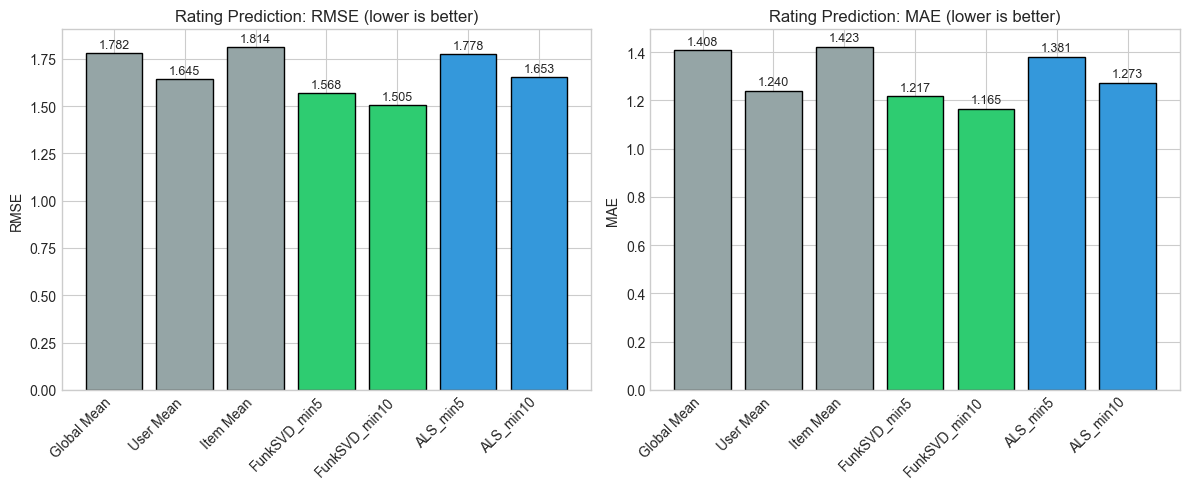

In [90]:
# Visualize rating prediction metrics
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

models_with_rmse = [m for m in model_order if all_results.get(m, {}).get('rmse') is not None]
rmse_vals = [all_results[m]['rmse'] for m in models_with_rmse]
mae_vals = [all_results[m]['mae'] for m in models_with_rmse]

colors = ['#95a5a6'] * 3 + ['#2ecc71'] * 2 + ['#3498db'] * 2
colors = colors[:len(models_with_rmse)]

ax1 = axes[0]
bars = ax1.bar(range(len(models_with_rmse)), rmse_vals, color=colors, edgecolor='black')
ax1.set_xticks(range(len(models_with_rmse)))
ax1.set_xticklabels(models_with_rmse, rotation=45, ha='right')
ax1.set_ylabel('RMSE')
ax1.set_title('Rating Prediction: RMSE (lower is better)')
for bar, val in zip(bars, rmse_vals):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{val:.3f}', ha='center', va='bottom', fontsize=9)

ax2 = axes[1]
bars = ax2.bar(range(len(models_with_rmse)), mae_vals, color=colors, edgecolor='black')
ax2.set_xticks(range(len(models_with_rmse)))
ax2.set_xticklabels(models_with_rmse, rotation=45, ha='right')
ax2.set_ylabel('MAE')
ax2.set_title('Rating Prediction: MAE (lower is better)')
for bar, val in zip(bars, mae_vals):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{val:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('../experiments/similarity_rating_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

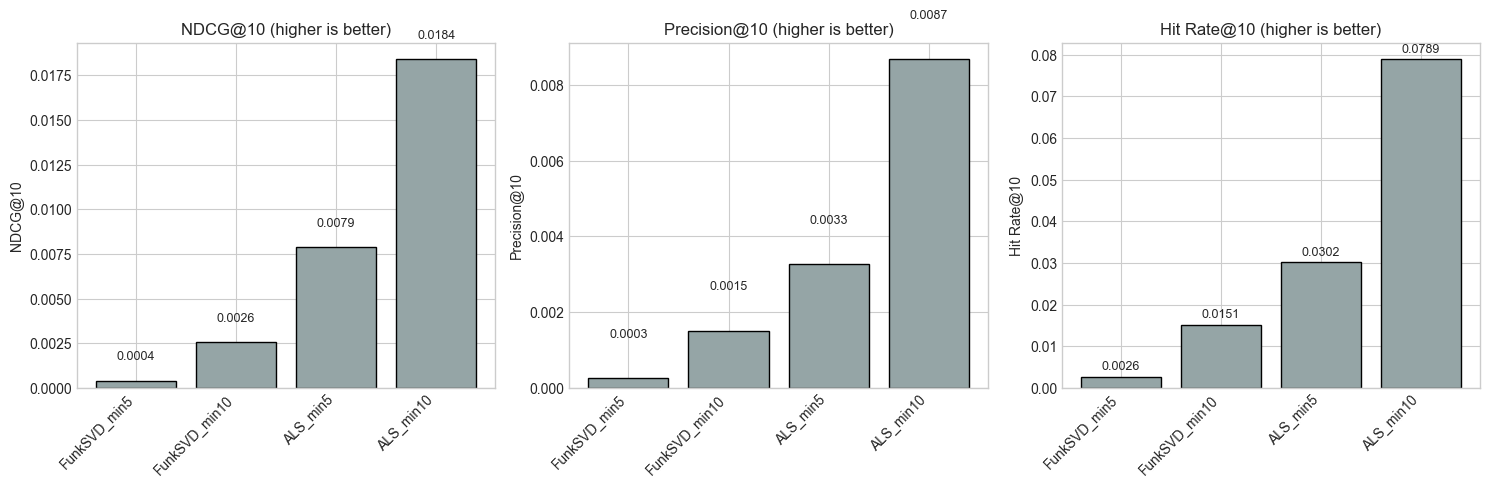

In [91]:
# Visualize ranking metrics (only models that have ranking results)
ranking_models = [m for m in model_order if all_results.get(m, {}).get('ndcg@10') is not None]

if ranking_models:
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    ranking_colors = []
    for m in ranking_models:
        if 'CBF' in m:
            ranking_colors.append('#2ecc71')
        elif 'CF' in m:
            ranking_colors.append('#3498db')
        else:
            ranking_colors.append('#95a5a6')
    
    for idx, (metric, title) in enumerate([
        ('ndcg@10', 'NDCG@10'),
        ('precision@10', 'Precision@10'),
        ('hit_rate@10', 'Hit Rate@10')
    ]):
        ax = axes[idx]
        vals = [all_results[m].get(metric, 0) for m in ranking_models]
        bars = ax.bar(range(len(ranking_models)), vals, color=ranking_colors, edgecolor='black')
        ax.set_xticks(range(len(ranking_models)))
        ax.set_xticklabels(ranking_models, rotation=45, ha='right')
        ax.set_ylabel(title)
        ax.set_title(f'{title} (higher is better)')
        for bar, val in zip(bars, vals):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                    f'{val:.4f}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.savefig('../experiments/similarity_ranking_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("No ranking results to visualize.")

## 6. Example Recommendations

In [92]:
# Show example recommendations for a few users
sample_users = list(set(train_df['user_id'].unique()) & set(test_df['user_id'].unique()))[-600:-595]

for user_id in sample_users:
    uidx = svd_model.user2idx.get(user_id)
    print(uidx is None)
    print(f"\n{'='*60}")
    print(f"User: {user_id}")
    print(f"{'='*60}")
    
    # User's training history
    user_train = train_df[train_df['user_id'] == user_id].merge(
        books[['isbn', 'title', 'author']], on='isbn', how='left'
    ).sort_values('rating', ascending=False)
    
    print(f"\nTraining history (top 5 by rating):")
    for _, row in user_train.head(5).iterrows():
        title = str(row.get('title', 'Unknown'))[:50]
        author = str(row.get('author', 'Unknown'))[:30]
        print(f"  [{row['rating']:.0f}] {title} — {author}")
    
    # Test items (what they actually rated)
    user_test = test_df[test_df['user_id'] == user_id].merge(
        books[['isbn', 'title', 'author']], on='isbn', how='left'
    ).sort_values('rating', ascending=False)
    
    print(f"\nTest items (rated ≥6 = relevant):")
    for _, row in user_test.head(5).iterrows():
        relevant = '✓' if row['rating'] >= 6 else ' '
        title = str(row.get('title', 'Unknown'))[:50]
        print(f"  [{row['rating']:.0f}]{relevant} {title}")
    
    # FunkSVD and ALS recommendations
    exclude = set(train_df[train_df['user_id'] == user_id]['isbn'])
    svd_recs = svd_model.recommend(user_id, 5, exclude)
    als_recs = als_model.recommend(user_id, 5, exclude)
    
    print(f"\FunksSVD Top-5 Recommendations:")
    for isbn in range(5):
        book_info = books[books['isbn'] == svd_recs[isbn]]
        if len(book_info) > 0:
            title = str(book_info.iloc[0].get('title', 'Unknown'))[:50]
            author = str(book_info.iloc[0].get('author', 'Unknown'))[:30]
            print(f"  → {title} — {author}")
        else:
            print(f"  → {isbn}")

    print("="*60)

    print(f"\ALS TOP-5 Recommendations:")
    for isbn in range(5):
        book_info = books[books['isbn'] == als_recs[isbn]]
        if len(book_info) > 0:
            title = str(book_info.iloc[0].get('title', 'Unknown'))[:50]
            author = str(book_info.iloc[0].get('author', 'Unknown'))[:30]
            print(f"  → {title} — {author}")
        else:
            print(f"  → {isbn}")

False

User: 238419

Training history (top 5 by rating):
  [10] Patriot Games (Jack Ryan Novels) — Tom Clancy
  [10] Nightmares & Dreamscapes — Stephen King
  [8] Clear and Present Danger (Jack Ryan Novels) — Tom Clancy
  [8] Without Remorse — Tom Clancy
  [7] The Cardinal of the Kremlin (Jack Ryan Novels) — Tom Clancy

Test items (rated ≥6 = relevant):
  [10]✓ The Door to December
  [8]✓ Dark Paradise
\FunksSVD Top-5 Recommendations:
  → Dilbert: A Book of Postcards — Scott Adams
  → The Two Towers (The Lord of the Rings, Part 2) — J. R. R. Tolkien
  → Harry Potter and the Chamber of Secrets Postcard B — J. K. Rowling
  → My Sister's Keeper : A Novel (Picoult, Jodi) — Jodi Picoult
  → Fox in Socks (I Can Read It All by Myself Beginner — Dr. Seuss
\ALS TOP-5 Recommendations:
  → The Tao of Pooh — Benjamin Hoff
  → Angels & Demons — Dan Brown
  → Skeleton Crew — Stephen King
  → The Catcher in the Rye — J.D. Salinger
  → The Remnant: On the Brink of Armageddon (Left Behi — Tim LaHaye
Fa

In [17]:
print("P norm:", np.linalg.norm(svd_model.P))
print("Q norm:", np.linalg.norm(svd_model.Q))
print("bu std:", svd_model.bu.std(), "bi std:", svd_model.bi.std())

P norm: 1.065013540390648
Q norm: 1.1024374700827801
bu std: 0.5910418440491834 bi std: 0.41972654383507146


In [117]:
def score_components(model, user_id, isbn, model_name):
    uidx = model.user2idx.get(user_id)
    iidx = model.item2idx.get(isbn)

    mu = model.mu
    dot = float(model.P[uidx] @ model.Q[iidx]) if (uidx is not None and iidx is not None) else 0.0
    if model_name == 'funksvd':
        bu = model.bu[uidx] if uidx is not None else 0.0
        bi = model.bi[iidx] if iidx is not None else 0.0
        return mu, bu, bi, dot, mu+bu+bi+dot
    else: 
        return mu, dot, mu+dot
    
print("let's take a closer look at one user")    
for i in range(9):
    books = list(test_df[test_df['user_id'] == '11676']['isbn'].tail(10))
    ratings = list(test_df[test_df['user_id'] == '11676']['rating'].tail(10))
    print("original book rating: ", ratings[i])
    mu, bu, bi, dot, total = score_components(svd_model, '11676', books[i], 'funksvd')
    print('FunkSVD parameters mu:', mu, 'bu:', bu, 'bi:', bi, 'dot:', dot, 'total:', total)
    mu, dot, total = score_components(als_model, '11676', books[i], 'als')
    print('FunkSVD parameters mu:', mu, 'dot:', dot, 'total:', total)


let's take a closer look at one user
original book rating:  8
FunkSVD parameters mu: 7.955336839113133 bu: -0.1094957559644351 bi: -0.24650666149767939 dot: -2.9189146509093843e-05 total: 7.59930523250451
FunkSVD parameters mu: 7.955336839113133 dot: 0.29669135999063045 total: 8.252028199103764
original book rating:  8
FunkSVD parameters mu: 7.955336839113133 bu: -0.1094957559644351 bi: -0.14563646078467365 dot: -1.716423270755463e-05 total: 7.7001874581313166
FunkSVD parameters mu: 7.955336839113133 dot: 0.4132109823688682 total: 8.368547821482
original book rating:  5
FunkSVD parameters mu: 7.955336839113133 bu: -0.1094957559644351 bi: 0.01968476621290162 dot: -4.8727505640190006e-05 total: 7.865477121855959
FunkSVD parameters mu: 7.955336839113133 dot: -0.7068776199134489 total: 7.248459219199684
original book rating:  8
FunkSVD parameters mu: 7.955336839113133 bu: -0.1094957559644351 bi: -0.3845969456534764 dot: -0.00016429272984295942 total: 7.461079844765378
FunkSVD parameters mu

## 7. Analysis and Discussion

### Matrix Factorization
Book-crossing dataset is extremely sparce and that created main challenge for matrix factorization methods, as their main idea is to learn meaningful representations of user-item interactions and with most users having only few ratings models fail to reliably infer latent dimensions. We have tested two scenarios for both approaches: filtered only users with minimum 5 ratings and only users with minimum 10 ratings. Raising up the threshold reduces dataset dramatically, but as a result final matrix is less sparse. Consequently, it lifted metrics NDCG@10, Precision@10 and Hit@10 significantly for both algorithms. 

### 7.1 ALS
For its ratings ALS uses global mean and learned factor, which is unique for each item-user combination. In results we can see that though ALS has larger RMSE and MAE then FunkSVD, it perform much better in terms of NDCG@10, Precision@10 and Hit@10. In top-5 recommendations by ALS it is obvious that ALS recommends **different** books to different users. 

Still, final results are really low - our best performing model ALS with users with minimum 10 ratings - showed next metrics:
* NDCG@10 = 0.0184, meaning that model's placing relevant items rarely, and when it does, often not very high
* Precision@10 = 0.0087, meaning that on average model predicts 0.09 relevant books in the top-10 per user
* Hit@10 = 0.0789, meaning 8 users out of 100 have a “hit”

### 7.2 FunkSVD
FunkSVD uses global mean, user bias, item bias and learned factor for combinations of user-item as well. It has the smallest RMSE and MAE across all compared models, however it performs much worse in comparison to ALS based on NDCG@10, Precision@10 and Hit@10. After examining top-5 recommendations by FunkSVD we could see that it recommends same 5 books to all the users, meaning that in our implementation it collapsed to bias-only/popularity ranking. 

Global mean is fixed for all candidates, user bias is the same across all items, so prediction is mostly driven by learned factor and item bias term. After we have printed all values for one user, we have noticed that dot product is usually really small, compared to biases and that's exactly the reason behind strange behaviour of FunkSVD: item biased is responsible for all the rankings and model outputs just top-5 books in the dataset. 

FunkSVD achieves the lowest RMSE and MAE, indicating strong performance on the rating-prediction objective. However, its very low ranking metrics (Precision@10, HitRate@10, nDCG@10) suggest that the model is not effectively separating a user’s relevant items from non-relevant ones in the top-K list. This can occur when the model relies mainly on the global mean and bias terms (or produces predictions close to the mean), which is a conservative strategy that minimizes squared error under sparse and noisy data, but does not necessarily optimize ranking quality.

